# Generation of hyperspectral samples using Wasserstein-GANs

Wasserstein-GANs are Generative Adversarial Models that can be used to generate synthetic data that approximates a specific input distribution of real data.

In this notebook, we show how to use such a tool to generate *ex nihilo* synthetic hyperspectral samples.

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torch
torch.cuda.is_available()

True

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.utils.data
from scipy.io import loadmat
from skimage import io
from PIL import Image


We load the Pavia University dataset. The `.mat` files are available on [this website](http://www.ehu.eus/ccwintco/index.php?title=Hyperspectral_Remote_Sensing_Scenes).

In [3]:
# img = loadmat('./PaviaU.mat')['paviaU']
# gt = loadmat('./PaviaU_gt.mat')['paviaU_gt']
# mask = np.random.randint(0, 100, gt.shape) < 5
# train_gt = np.copy(gt)
# train_gt[np.nonzero(~mask)] = 0
# test_gt = np.copy(gt)
# test_gt[train_gt > 0] = 0
# rgb = img[:,:,(55,41,12)]
# rgb = (255 * (rgb.astype(np.float32) - rgb.min())/(rgb.max() - rgb.min())).astype(np.uint8)
# print(np.shape(img))
# print(np.shape(gt))
# print(np.shape(train_gt))
# print(np.shape(rgb))

In [4]:
# print(img[0][0])
# print(img[img > 1])
# counts = np.asarray(np.unique(gt,return_counts=True))
# print(counts)

In [5]:

# gt =  np.rot90(gt,1,(0,1))

# classes = np.array([
#     [153 ,  0 ,  0], #unspecified
#     [  0 ,  0 ,255], #roads
#     [  0, 255 ,  0], #vegetation
#     [  0 ,255 ,255], #water
#     [255 ,  0 ,0],#buidings 
#     [255 ,127 , 80]#cars
# ])
# # d = {
# #     repr([153 ,  0 ,  0]): 0,
# #     repr([0 ,  0 ,255]): 1,
# #     repr([ 0, 255 ,  0]): 2,
# #     repr([ 0 ,255 ,255]): 3,
# #     repr([255 ,  0 ,0]): 4,
# #     repr([255 ,127 , 80]): 5,
# # }
# gt_temp = np.zeros((gt.shape[0],gt.shape[1]))

# for i in range(gt.shape[0]):
#     for j in range(gt.shape[1]):
#         val = gt[i][j]
#         for id in range(len(classes)):
#             if np.array_equal(val, classes[id]):
#                 gt_temp[i][j] = id
        
        
# gt = gt_temp        
# gt_new = Image.fromarray(gt)
# gt_new.save('gt_new.tif')

In [6]:
# ae_img = io.imread('C:\\Users\\golde\\Documents\\GitHub\\AeroRIT\\Aerial Data\\Collection\\image_hsi_radiance.tif')
# ae_img = np.rot90(ae_img,1,(0,2))
# pavia_img = loadmat('./PaviaU.mat')['paviaU']

In [7]:
# print(ae_img[233][354])
# print(pavia_img[233][235])
# _counts = np.asarray(np.unique(ae_img,return_counts=True))
# print(len(_counts[0]),_counts.T)
# _counts = np.asarray(np.unique(pavia_img,return_counts=True))
# print(len(_counts[0]),_counts.T)

In [8]:
img = io.imread('C:\\Users\\golde\\Documents\\GitHub\\AeroRIT\\Aerial Data\\Collection\\image_hsi_radiance.tif')
img_rgb = io.imread('C:\\Users\\golde\\Documents\\GitHub\\AeroRIT\\Aerial Data\\Collection\\image_rgb.tif')
# img = io.imread('E:\\Accessories\\Documents\\Python Scripts\\AeroRIT\\Aerial Data\\Collection\\image_hsi_radiance.tif')
# img_rgb = io.imread('E:\\Accessories\\Documents\\Python Scripts\\AeroRIT\\Aerial Data\\Collection\\image_rgb.tif')
# E:\Accessories\Documents\Python Scripts\AeroRIT\Aerial Data
# gt = io.imread('C:\\Users\\golde\\Documents\\GitHub\\AeroRIT\\Aerial Data\\Collection\\image_labels.tif')
gt = io.imread('./gt_new.tif')
gt = gt.astype(int)

img = np.rot90(img,1,(0,2))
img_rgb =  np.rot90(img_rgb,1,(0,1))

# crop images
crop_offset = 348
crop_w = 610*2 + crop_offset
crop_h = 340*2 + crop_offset

img = img[crop_offset:crop_w,crop_offset:crop_h,:]
img_rgb = img_rgb[crop_offset:crop_w,crop_offset:crop_h,:]
gt = gt[crop_offset:crop_w,crop_offset:crop_h]
# img = img[:3974,:1972,:]
# img_rgb = img_rgb[:3974,:1972,:]
# gt = gt[:3974,:1972]
counts = np.asarray(np.unique(gt,return_counts=True))
print(counts)
print(np.shape(img))
print(np.shape(img_rgb))
print(gt.shape)

mask = np.random.randint(0, 100, gt.shape) < 5
train_gt = np.copy(gt)
train_gt[np.nonzero(~mask)] = 0
test_gt = np.copy(gt)
test_gt[train_gt > 0] = 0
rgb = img_rgb
rgb = (255 * (rgb.astype(np.float32) - rgb.min())/(rgb.max() - rgb.min())).astype(np.uint8)
print(np.shape(img))
print(np.shape(gt))
print(np.shape(train_gt))
print(np.shape(rgb))




[[     0      1      2      3      4      5]
 [  1446 245740 465426   5164 101880   9944]]
(1220, 680, 51)
(1220, 680, 3)
(1220, 680)
(1220, 680, 51)
(1220, 680)
(1220, 680)
(1220, 680, 3)


The ground truth is shown below. We sample 10% from the pixels as training samples.

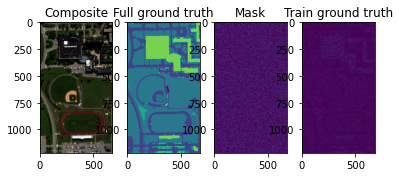

In [9]:
fig = plt.figure()
fig.add_subplot(141)
plt.imshow(rgb)
plt.title("Composite")
fig.add_subplot(142)
plt.imshow(gt)
plt.title("Full ground truth")
fig.add_subplot(143)
plt.imshow(mask)

plt.title("Mask")
fig.add_subplot(144)
plt.imshow(train_gt)
plt.title("Train ground truth")
plt.show()

We define a `HyperX` class to hold the dataset. Note that the label is encoded as a one-hot vector.

In [10]:
from skimage import morphology

class HyperX(torch.utils.data.Dataset):
    
    def __init__(self, data, ground_truth, semi=False):
        super(HyperX, self).__init__()
        # print('init dataloader')
        # Normalize the data in [0,1]
        data = (data - data.min()) / (data.max() - data.min())
        self.data = data
        self.gt = ground_truth
        self.n_classes = len(np.unique(ground_truth))
        if semi:
            # Semi-supervision, include neighbours at 50px
            x_pos, y_pos = np.nonzero(morphology.dilation(ground_truth > 0, morphology.disk(50)))
        else:
            x_pos, y_pos = np.nonzero(ground_truth)
        self.indices = [idx for idx in zip(x_pos, y_pos)]
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, i):
        x, y = self.indices[i]
        data = self.data[x,y]
        # Get the label in one-hot encoded style
        # print(self.n_classes,x, y,np.eye(self.n_classes),self.gt[x, y])
        label = np.asarray(np.eye(self.n_classes)[self.gt[x, y]], dtype='int64')
        return torch.from_numpy(data), torch.from_numpy(label)

In [11]:
import os
import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

# Basic generator that maps: noise + condition -> fake samples
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        # LeakyReLU is preferred to keep gradients flowing even for negative activations
        self.generator = torch.nn.Sequential(
            torch.nn.Linear(z_dim + c_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, X_dim),
            torch.nn.Sigmoid() # smooth [0,1] outputs
        )
        self.apply(weight_init)

    def forward(self, z, c):
        # Concatenate the noise and condition
        inputs = torch.cat([z, c], 1)
        return self.generator(inputs)

# Basic fully connected discriminator: sample -> -infty -- fake - 0 - real -- +infty
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = torch.nn.Sequential(
            torch.nn.Linear(X_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, 1)
        )
        
        self.apply(weight_init)

    def forward(self, X):
        return self.discriminator(X)

# Basic fully connected classifier: sample -> class
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.discriminator = torch.nn.Sequential(
            torch.nn.Linear(X_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, h_dim),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(h_dim, c_dim)
        )
        
        self.apply(weight_init)

    def forward(self, X):
        return self.discriminator(X)

In [12]:
mb_size = 256 # Batch size
z_dim = 30   # Noise dimension
X_dim = img.shape[-1] # Number of bands
print(X_dim)
h_dim = 512  # Hidden layer size
d_step = 5   # Number of discriminator training steps for ea ch generator training step
lr = 5e-5    # Learning rate
c_weight = 0.2 # Auxiliary classifier weight
flip_percentage = 0.0 # Proportion of label flipping
mixup_alpha = 0.1 # Mixup
semi_supervised = True # semi-supervision (set to True to include unlabeled samples)

# Build the dataset and data loader
data_loader = torch.utils.data.DataLoader(
    HyperX(img, train_gt if semi_supervised else gt), batch_size=mb_size, shuffle=True)
# c_dim = condition vector size
c_dim = data_loader.dataset.n_classes
print(c_dim)
# Ignore the class 0
class_weights = torch.ones((c_dim))
class_weights[0] = 0.
class_weights = class_weights.cuda()

51
6


In [13]:
# Initialize weights using the He et al. (2015) policy.
def weight_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d, nn.Conv3d, nn.ConvTranspose3d)):
        torch.nn.init.kaiming_normal_(m.weight.data)

# Spherical interpolation between two vectors on the unit hypersphere
# See : https://github.com/soumith/dcgan.torch/issues/14
def slerp(val, low, high):
    omega = np.arccos(np.clip(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)), -1, 1))
    so = np.sin(omega)
    if so == 0:
        return (1.0-val) * low + val * high # L'Hopital's rule/LERP
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega) / so * high

def lerp(val, low, high):
    return (1.0-val) * low + val * high # L'Hopital's rule/LERP

# Gradient penalty from the Improved WGAN training
# From : https://github.com/EmilienDupont/wgan-gp
# Use penalty_weight set at 10, as suggested in the paper
def calc_gradient_penalty(netD, real_data, generated_data, penalty_weight=10):
        batch_size = real_data.size()[0]

        alpha = torch.rand(batch_size, 1) if real_data.dim() == 2 else torch.rand(batch_size, 1, 1, 1)
        alpha = alpha.expand_as(real_data)
        alpha = alpha.cuda()
        
        interpolated = alpha * real_data + (1 - alpha) * generated_data
        #interpolated = Variable(interpolated, requires_grad=True)
        interpolated.requires_grad_()
        interpolated = interpolated.cuda()

        # Calculate probability of interpolated examples
        prob_interpolated = netD(interpolated)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda(),
                               create_graph=True, retain_graph=True)[0]

        # Gradients have shape (batch_size, num_channels, img_width, img_height),
        # so flatten to easily take norm per example in batch
        gradients = gradients.view(batch_size, -1)

        # Derivatives of the gradient close to 0 can cause problems because of
        # the square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return penalty_weight * ((gradients_norm - 1) ** 2).mean()
    
def reset_grad(*nets):
    for net in nets:
        net.zero_grad()
        
def plot_mean_std(samples):
    mean_spectrum = np.mean(samples, axis=0)
    std_spectrum = np.std(samples, axis=0)
    plt.plot(mean_spectrum - std_spectrum, linestyle='dotted', label='-std')
    plt.plot(mean_spectrum, label='mean')
    plt.plot(mean_spectrum + std_spectrum, linestyle='dotted', label='+std')

  0%|                                                                                       | 0/100000 [00:00<?, ?it/s]

Iter-0; D_loss: -1.9513721466064453; G_loss: 2.7096848487854004; C_loss: 1.409038782119751


C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


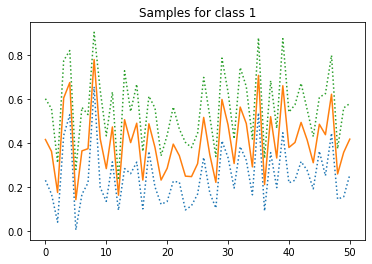

  1%|▋                                                                         | 1000/100000 [01:51<3:06:02,  8.87it/s]

Iter-1000; D_loss: -0.10334262251853943; G_loss: -0.1903020739555359; C_loss: 0.12510620057582855


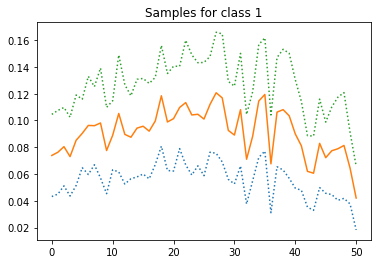

  2%|█▍                                                                        | 2000/100000 [03:41<2:54:56,  9.34it/s]

Iter-2000; D_loss: -0.056971438229084015; G_loss: -0.1674841195344925; C_loss: 0.054334595799446106


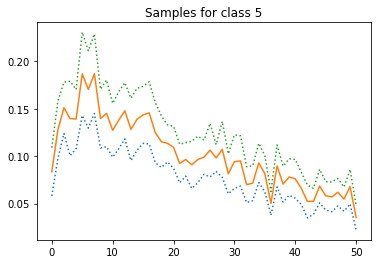

  3%|██▏                                                                       | 3000/100000 [05:29<2:56:56,  9.14it/s]

Iter-3000; D_loss: -0.03745175898075104; G_loss: -0.1335044503211975; C_loss: 0.07183225452899933


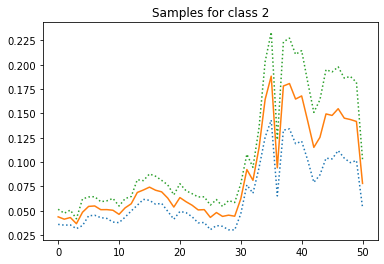

  4%|██▉                                                                       | 4000/100000 [07:16<2:55:23,  9.12it/s]

Iter-4000; D_loss: -0.022255606949329376; G_loss: -0.08384489268064499; C_loss: 0.03970491513609886


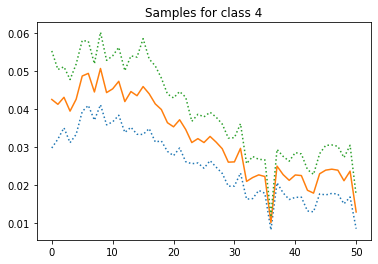

  5%|███▋                                                                      | 5000/100000 [09:03<2:47:37,  9.45it/s]

Iter-5000; D_loss: -0.02620057202875614; G_loss: -0.10536719858646393; C_loss: 0.03275403380393982


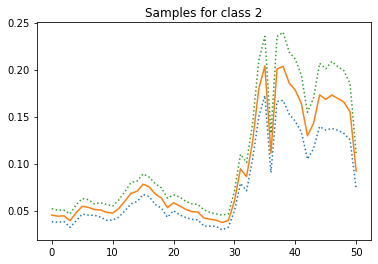

  6%|████▍                                                                     | 6000/100000 [10:50<2:45:32,  9.46it/s]

Iter-6000; D_loss: -0.018903929740190506; G_loss: -0.13438856601715088; C_loss: 0.03072590008378029


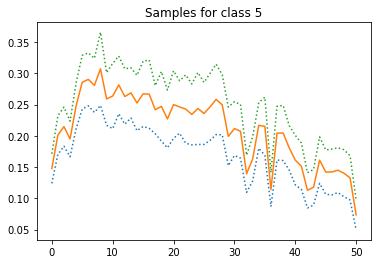

  7%|█████▏                                                                    | 7000/100000 [12:37<2:39:01,  9.75it/s]

Iter-7000; D_loss: -0.005383454263210297; G_loss: -0.16326001286506653; C_loss: 0.03222920745611191


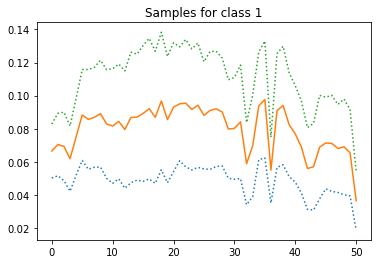

  8%|█████▉                                                                    | 8000/100000 [14:24<2:36:26,  9.80it/s]

Iter-8000; D_loss: -0.009090842679142952; G_loss: -0.2076244056224823; C_loss: 0.03240513056516647


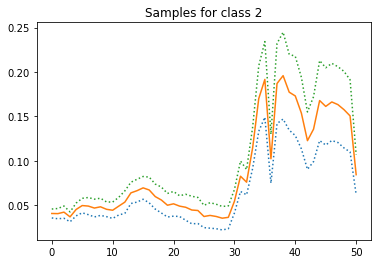

  9%|██████▋                                                                   | 9000/100000 [16:11<2:34:28,  9.82it/s]

Iter-9000; D_loss: -0.009747087955474854; G_loss: -0.2207428216934204; C_loss: 0.029280999675393105


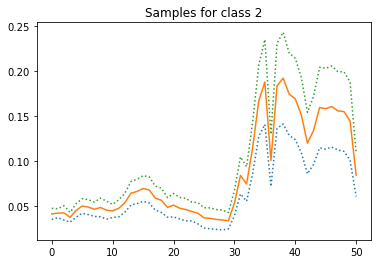

 10%|███████▎                                                                 | 10000/100000 [17:58<2:40:15,  9.36it/s]

Iter-10000; D_loss: -0.008509015664458275; G_loss: -0.23252668976783752; C_loss: 0.026347868144512177


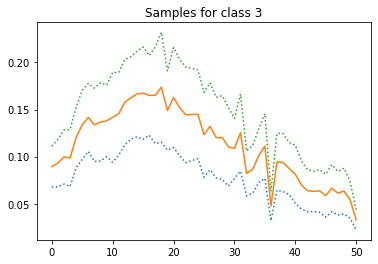

 11%|████████                                                                 | 11000/100000 [19:45<2:38:14,  9.37it/s]

Iter-11000; D_loss: -0.005730068311095238; G_loss: -0.2259855568408966; C_loss: 0.035487137734889984


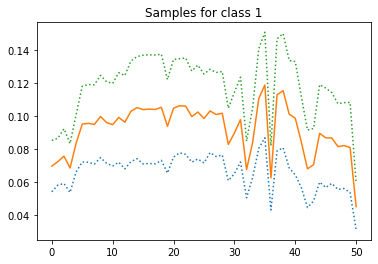

 12%|████████▊                                                                | 12000/100000 [21:32<2:33:51,  9.53it/s]

Iter-12000; D_loss: -0.004597954452037811; G_loss: -0.22592036426067352; C_loss: 0.025779640302062035


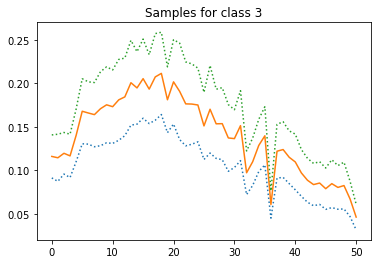

 13%|█████████▍                                                               | 13000/100000 [23:19<2:41:16,  8.99it/s]

Iter-13000; D_loss: -0.007196763064712286; G_loss: -0.22667640447616577; C_loss: 0.02167646586894989


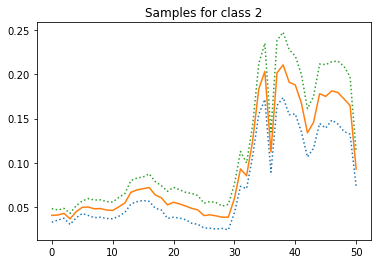

 14%|██████████▏                                                              | 13999/100000 [25:06<2:30:58,  9.49it/s]

Iter-14000; D_loss: -0.008658463135361671; G_loss: -0.21948641538619995; C_loss: 0.015555910766124725


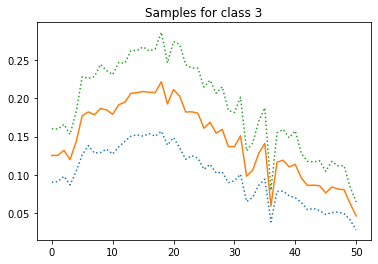

 15%|██████████▉                                                              | 14999/100000 [26:53<2:32:45,  9.27it/s]

Iter-15000; D_loss: -0.01969330385327339; G_loss: -0.21114403009414673; C_loss: 0.02566593699157238


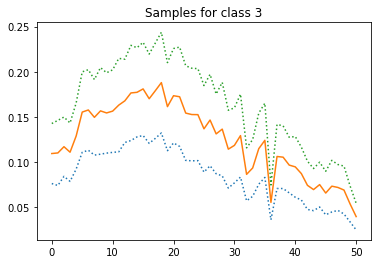

 16%|███████████▋                                                             | 16000/100000 [28:40<2:25:34,  9.62it/s]

Iter-16000; D_loss: -0.004004206042736769; G_loss: -0.2108520269393921; C_loss: 0.024240918457508087


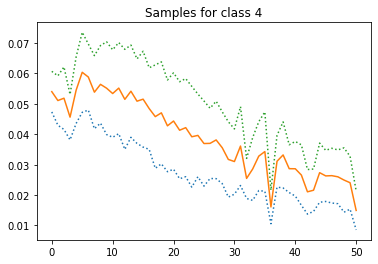

 17%|████████████▍                                                            | 16999/100000 [30:27<2:30:14,  9.21it/s]

Iter-17000; D_loss: -0.004812673665583134; G_loss: -0.206374391913414; C_loss: 0.023582810536026955


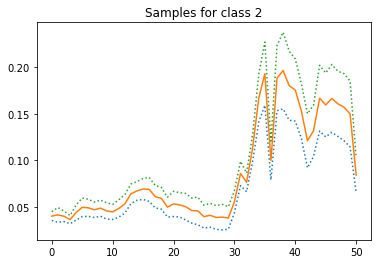

 18%|█████████████▏                                                           | 18000/100000 [32:14<2:22:32,  9.59it/s]

Iter-18000; D_loss: -0.0026734271086752415; G_loss: -0.1982700228691101; C_loss: 0.0209068451076746


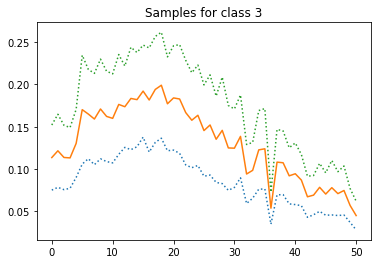

 19%|█████████████▊                                                           | 19000/100000 [34:04<2:37:58,  8.55it/s]

Iter-19000; D_loss: -0.004716177005320787; G_loss: -0.19483238458633423; C_loss: 0.01771005429327488


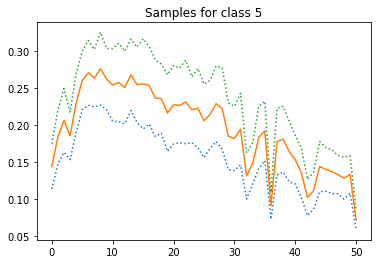

 20%|██████████████▌                                                          | 20000/100000 [35:58<2:20:36,  9.48it/s]

Iter-20000; D_loss: -0.02358156442642212; G_loss: -0.19418731331825256; C_loss: 0.03325437009334564


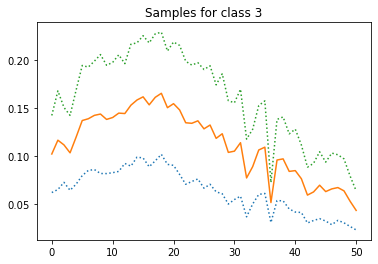

 21%|███████████████▎                                                         | 20999/100000 [37:49<2:24:09,  9.13it/s]

Iter-21000; D_loss: -0.0012597430031746626; G_loss: -0.1863938570022583; C_loss: 0.017484493553638458


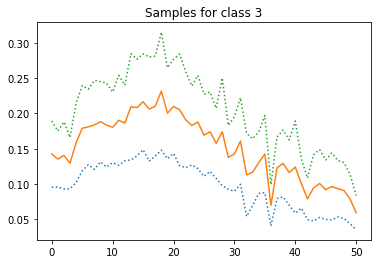

 22%|████████████████                                                         | 22000/100000 [39:37<2:16:07,  9.55it/s]

Iter-22000; D_loss: -0.0036406521685421467; G_loss: -0.18935655057430267; C_loss: 0.020148752257227898


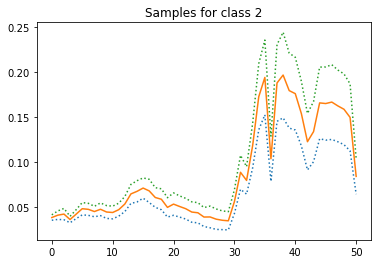

 23%|████████████████▊                                                        | 23000/100000 [41:24<2:15:30,  9.47it/s]

Iter-23000; D_loss: -0.003809741698205471; G_loss: -0.18823428452014923; C_loss: 0.018009444698691368


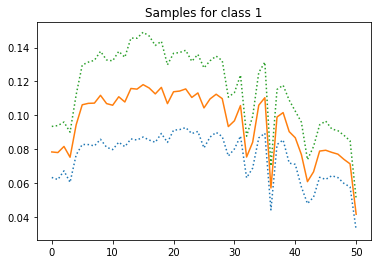

 24%|█████████████████▌                                                       | 24000/100000 [43:10<2:08:21,  9.87it/s]

Iter-24000; D_loss: -0.014701608568429947; G_loss: -0.18244418501853943; C_loss: 0.02883942425251007


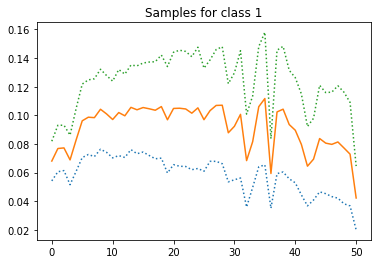

 25%|██████████████████▎                                                      | 25000/100000 [44:56<2:13:06,  9.39it/s]

Iter-25000; D_loss: -0.0037119367625564337; G_loss: -0.1812572479248047; C_loss: 0.01728680357336998


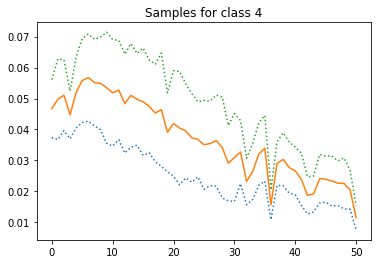

 26%|██████████████████▉                                                      | 25999/100000 [46:41<2:08:13,  9.62it/s]

Iter-26000; D_loss: -0.00019296910613775253; G_loss: -0.1759302169084549; C_loss: 0.022984003648161888


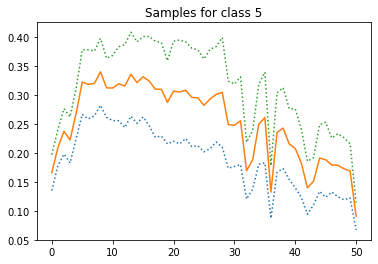

 27%|███████████████████▋                                                     | 27000/100000 [48:26<2:10:28,  9.32it/s]

Iter-27000; D_loss: -0.007284027989953756; G_loss: -0.17725318670272827; C_loss: 0.023249013349413872


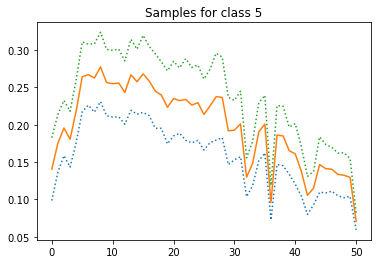

 28%|████████████████████▍                                                    | 28000/100000 [50:11<2:01:21,  9.89it/s]

Iter-28000; D_loss: 0.0011436609784141183; G_loss: -0.18076959252357483; C_loss: 0.01813386008143425


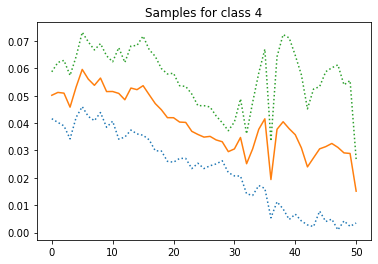

 29%|█████████████████████▏                                                   | 29000/100000 [51:56<1:59:09,  9.93it/s]

Iter-29000; D_loss: -0.0026588013861328363; G_loss: -0.17525315284729004; C_loss: 0.01520186010748148


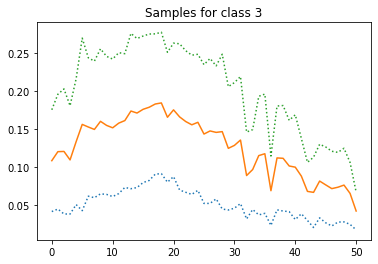

 30%|█████████████████████▉                                                   | 29999/100000 [53:41<2:07:00,  9.19it/s]

Iter-30000; D_loss: -0.004014503210783005; G_loss: -0.17923617362976074; C_loss: 0.01650613360106945


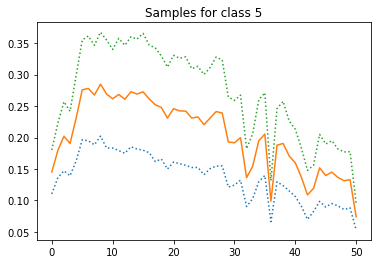

 31%|██████████████████████▋                                                  | 30999/100000 [55:27<2:01:30,  9.46it/s]

Iter-31000; D_loss: -0.012354742735624313; G_loss: -0.17780718207359314; C_loss: 0.02390783652663231


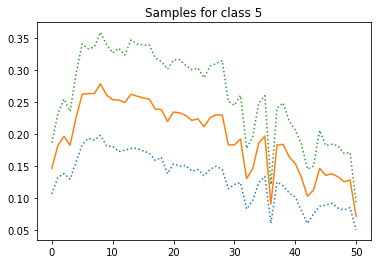

 32%|███████████████████████▎                                                 | 32000/100000 [57:13<2:01:20,  9.34it/s]

Iter-32000; D_loss: -0.002432043431326747; G_loss: -0.17275935411453247; C_loss: 0.015321782790124416


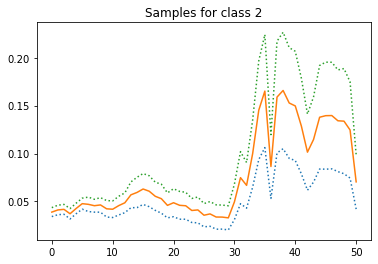

 33%|████████████████████████                                                 | 33000/100000 [58:58<1:57:38,  9.49it/s]

Iter-33000; D_loss: -0.004407084081321955; G_loss: -0.1780358850955963; C_loss: 0.022815678268671036


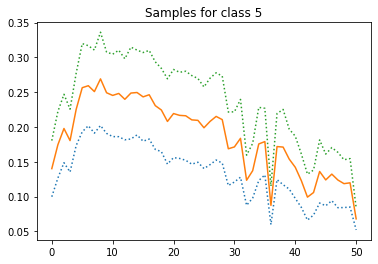

 34%|████████████████████████▏                                              | 34000/100000 [1:00:44<1:51:48,  9.84it/s]

Iter-34000; D_loss: -0.00485427537932992; G_loss: -0.1751866638660431; C_loss: 0.022753439843654633


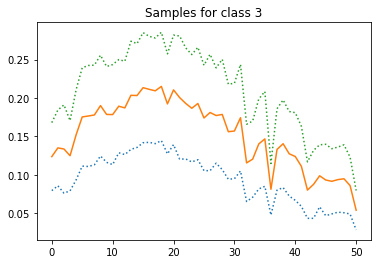

 35%|████████████████████████▊                                              | 34999/100000 [1:02:30<1:48:15, 10.01it/s]

Iter-35000; D_loss: -0.001057810615748167; G_loss: -0.18373730778694153; C_loss: 0.020556077361106873


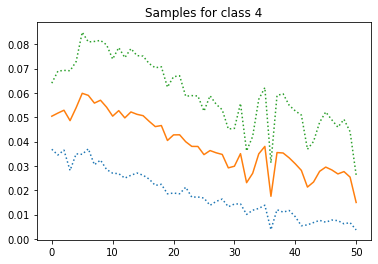

 36%|█████████████████████████▌                                             | 36000/100000 [1:04:16<1:50:58,  9.61it/s]

Iter-36000; D_loss: -0.004643854219466448; G_loss: -0.18650083243846893; C_loss: 0.0168725848197937


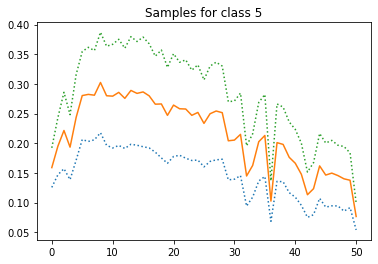

 37%|██████████████████████████▎                                            | 37000/100000 [1:06:02<1:52:23,  9.34it/s]

Iter-37000; D_loss: -0.002081718761473894; G_loss: -0.18431909382343292; C_loss: 0.01851281337440014


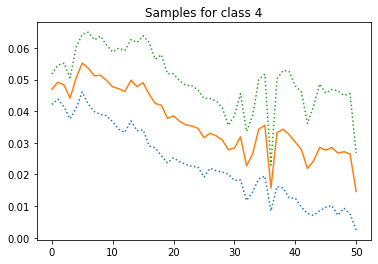

 38%|██████████████████████████▉                                            | 38000/100000 [1:07:47<1:47:58,  9.57it/s]

Iter-38000; D_loss: -0.0022825547493994236; G_loss: -0.18589726090431213; C_loss: 0.019941696897149086


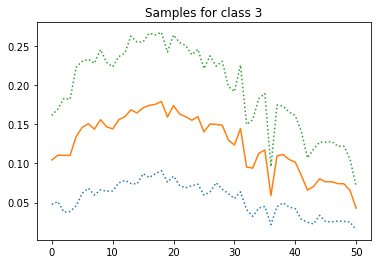

 39%|███████████████████████████▋                                           | 39000/100000 [1:09:33<1:45:52,  9.60it/s]

Iter-39000; D_loss: -0.004074794240295887; G_loss: -0.19031204283237457; C_loss: 0.015959862619638443


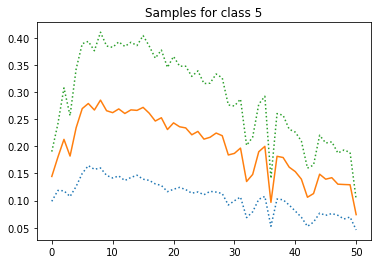

 40%|████████████████████████████▍                                          | 39999/100000 [1:11:18<1:46:39,  9.38it/s]

Iter-40000; D_loss: 0.0017444491386413574; G_loss: -0.187385693192482; C_loss: 0.014399508945643902


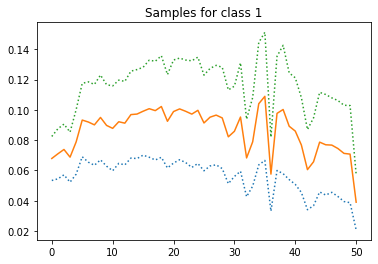

 41%|█████████████████████████████                                          | 41000/100000 [1:13:04<1:42:43,  9.57it/s]

Iter-41000; D_loss: -0.0024225672241300344; G_loss: -0.18917015194892883; C_loss: 0.014924529008567333


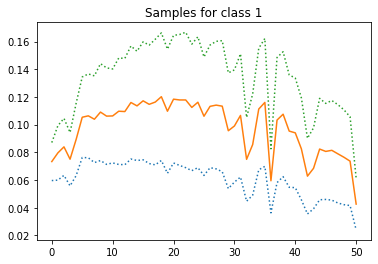

 42%|█████████████████████████████▊                                         | 42000/100000 [1:14:49<1:38:39,  9.80it/s]

Iter-42000; D_loss: -0.0006647780537605286; G_loss: -0.18399092555046082; C_loss: 0.016394246369600296


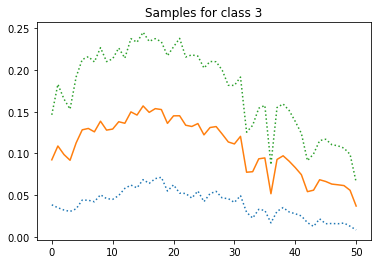

 43%|██████████████████████████████▌                                        | 43000/100000 [1:16:35<1:38:28,  9.65it/s]

Iter-43000; D_loss: -0.002129455329850316; G_loss: -0.1892957240343094; C_loss: 0.014458119869232178


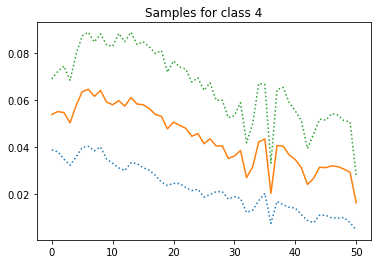

 44%|███████████████████████████████▏                                       | 44000/100000 [1:18:20<1:35:16,  9.80it/s]

Iter-44000; D_loss: -0.0028703585267066956; G_loss: -0.18503724038600922; C_loss: 0.010072022676467896


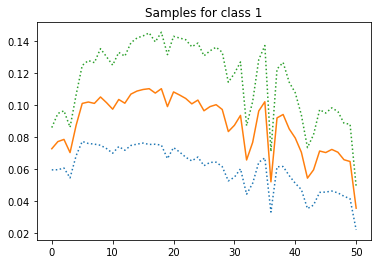

 45%|███████████████████████████████▉                                       | 45000/100000 [1:20:06<1:46:55,  8.57it/s]

Iter-45000; D_loss: -0.0006423441227525473; G_loss: -0.18907323479652405; C_loss: 0.013940222561359406


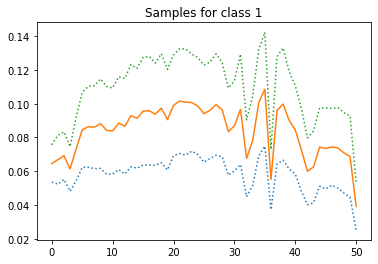

 46%|████████████████████████████████▋                                      | 46000/100000 [1:21:52<1:39:34,  9.04it/s]

Iter-46000; D_loss: -0.004177256487309933; G_loss: -0.18549303710460663; C_loss: 0.0208965502679348


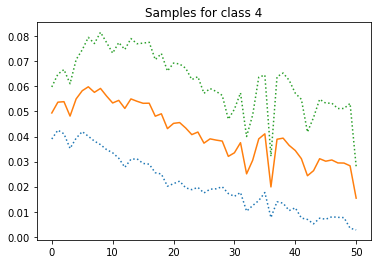

 47%|█████████████████████████████████▎                                     | 47000/100000 [1:23:37<1:35:38,  9.24it/s]

Iter-47000; D_loss: -0.005686955060809851; G_loss: -0.18717260658740997; C_loss: 0.017342356964945793


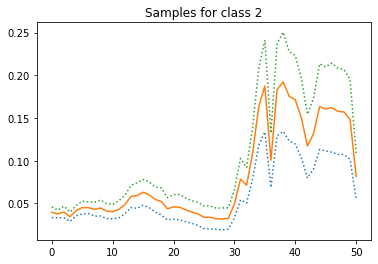

 48%|██████████████████████████████████                                     | 48000/100000 [1:25:23<1:33:17,  9.29it/s]

Iter-48000; D_loss: -0.0017435363261029124; G_loss: -0.18733973801136017; C_loss: 0.011809810996055603


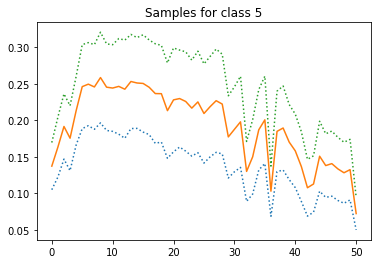

 49%|██████████████████████████████████▊                                    | 49000/100000 [1:27:09<1:25:52,  9.90it/s]

Iter-49000; D_loss: -0.0024900285061448812; G_loss: -0.19076718389987946; C_loss: 0.010897407308220863


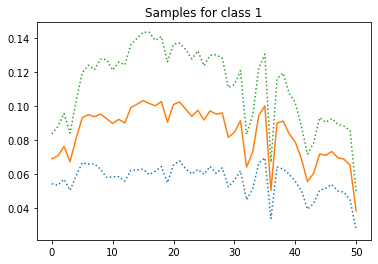

 50%|███████████████████████████████████▌                                   | 50000/100000 [1:28:53<1:29:10,  9.35it/s]

Iter-50000; D_loss: -0.0017006628913804889; G_loss: -0.18336568772792816; C_loss: 0.009493447840213776


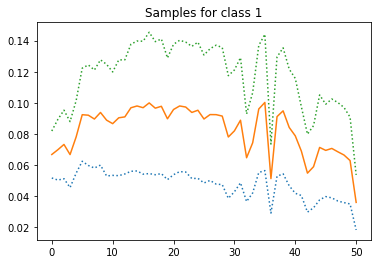

 51%|████████████████████████████████████▏                                  | 51000/100000 [1:30:39<1:29:25,  9.13it/s]

Iter-51000; D_loss: -0.0028231050819158554; G_loss: -0.18685537576675415; C_loss: 0.01603732816874981


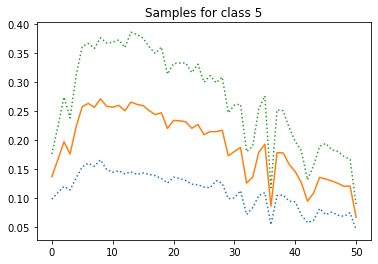

 52%|████████████████████████████████████▉                                  | 52000/100000 [1:32:24<1:22:26,  9.70it/s]

Iter-52000; D_loss: -0.003055014181882143; G_loss: -0.19062843918800354; C_loss: 0.012691127136349678


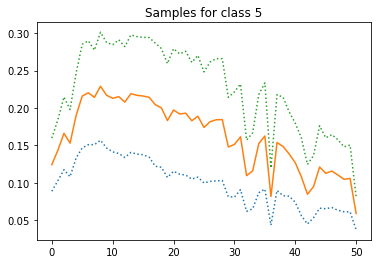

 53%|█████████████████████████████████████▋                                 | 53000/100000 [1:34:07<1:18:48,  9.94it/s]

Iter-53000; D_loss: -0.006634369492530823; G_loss: -0.18713654577732086; C_loss: 0.02182428352534771


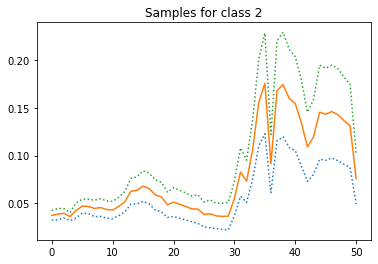

 54%|██████████████████████████████████████▎                                | 54000/100000 [1:35:50<1:16:16, 10.05it/s]

Iter-54000; D_loss: -0.002232471713796258; G_loss: -0.18746283650398254; C_loss: 0.008916574530303478


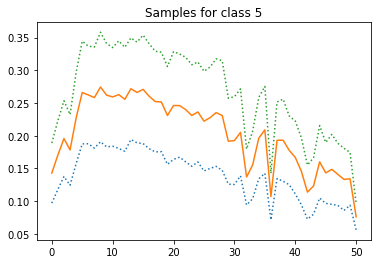

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 55%|███████████████████████████████████████                                | 55000/100000 [1:37:31<1:16:39,  9.78it/s]

Iter-55000; D_loss: -0.0009257089113816619; G_loss: -0.18667633831501007; C_loss: 0.012608122080564499


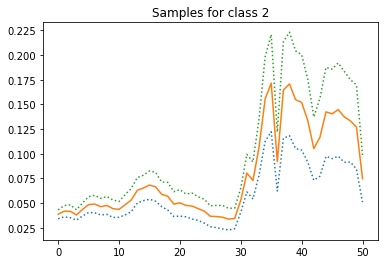

 56%|███████████████████████████████████████▊                               | 56000/100000 [1:39:14<1:12:43, 10.08it/s]

Iter-56000; D_loss: -0.002104396466165781; G_loss: -0.19228310883045197; C_loss: 0.012983803637325764


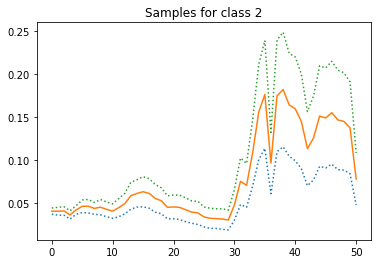

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 57%|████████████████████████████████████████▍                              | 57000/100000 [1:40:56<1:10:04, 10.23it/s]

Iter-57000; D_loss: -0.0008980147540569305; G_loss: -0.19662506878376007; C_loss: 0.009534349665045738


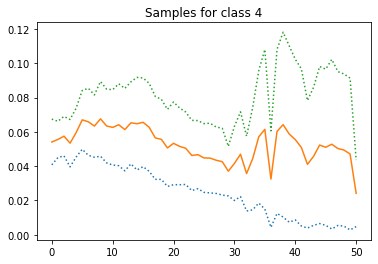

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 58%|█████████████████████████████████████████▏                             | 57999/100000 [1:42:38<1:11:49,  9.75it/s]

Iter-58000; D_loss: -0.00036684866063296795; G_loss: -0.1892538219690323; C_loss: 0.011996179819107056


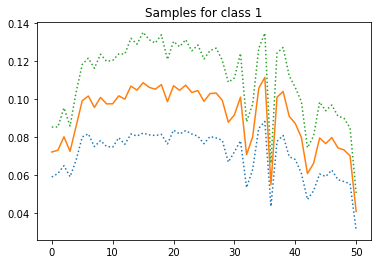

 59%|█████████████████████████████████████████▉                             | 59000/100000 [1:44:20<1:08:24,  9.99it/s]

Iter-59000; D_loss: -0.001808487344533205; G_loss: -0.19228887557983398; C_loss: 0.009703664109110832


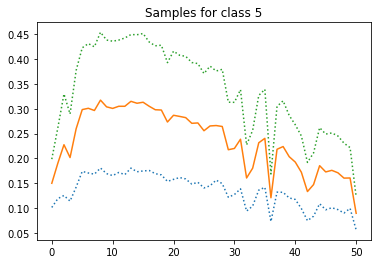

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 60%|██████████████████████████████████████████▌                            | 60000/100000 [1:46:02<1:09:31,  9.59it/s]

Iter-60000; D_loss: 0.0005063661374151707; G_loss: -0.18968290090560913; C_loss: 0.013089482672512531


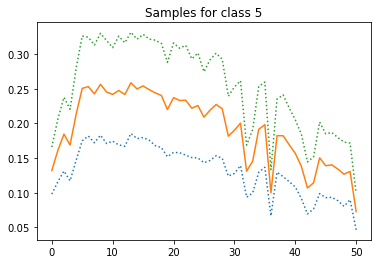

 61%|███████████████████████████████████████████▎                           | 61000/100000 [1:47:44<1:06:26,  9.78it/s]

Iter-61000; D_loss: -0.0006060448940843344; G_loss: -0.19126875698566437; C_loss: 0.01061159372329712


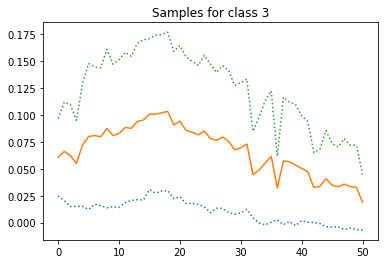

 62%|████████████████████████████████████████████                           | 62000/100000 [1:49:27<1:05:24,  9.68it/s]

Iter-62000; D_loss: 5.422648973762989e-05; G_loss: -0.1932014375925064; C_loss: 0.008995508775115013


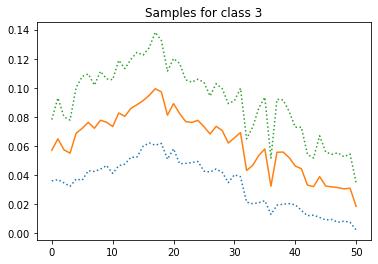

 63%|████████████████████████████████████████████▋                          | 62999/100000 [1:51:09<1:00:06, 10.26it/s]

Iter-63000; D_loss: -0.0036118319258093834; G_loss: -0.1910862773656845; C_loss: 0.01114125456660986


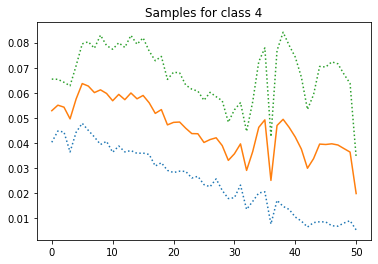

 64%|█████████████████████████████████████████████▍                         | 63999/100000 [1:52:50<1:02:03,  9.67it/s]

Iter-64000; D_loss: -0.0007695168023929; G_loss: -0.196429044008255; C_loss: 0.008610602468252182


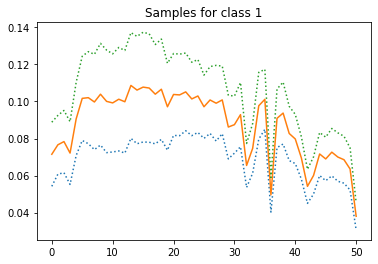

 65%|███████████████████████████████████████████████▍                         | 64999/100000 [1:54:32<59:05,  9.87it/s]

Iter-65000; D_loss: -0.0008184846956282854; G_loss: -0.1982029229402542; C_loss: 0.010752114467322826


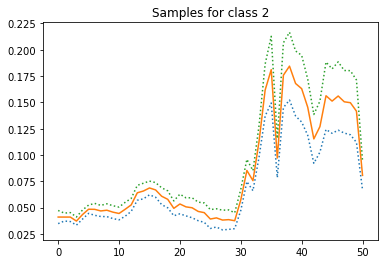

 66%|████████████████████████████████████████████████▏                        | 65999/100000 [1:56:14<58:55,  9.62it/s]

Iter-66000; D_loss: -0.002380026038736105; G_loss: -0.19483298063278198; C_loss: 0.012905127368867397


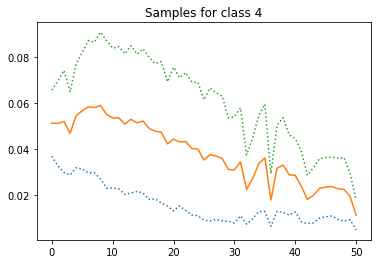

 67%|████████████████████████████████████████████████▉                        | 67000/100000 [1:57:56<53:58, 10.19it/s]

Iter-67000; D_loss: -0.0007639557588845491; G_loss: -0.19943633675575256; C_loss: 0.007502587046474218


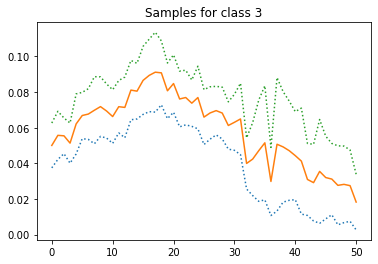

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 68%|█████████████████████████████████████████████████▋                       | 67999/100000 [1:59:34<50:20, 10.60it/s]

Iter-68000; D_loss: -0.002860286505892873; G_loss: -0.19305768609046936; C_loss: 0.010755428113043308


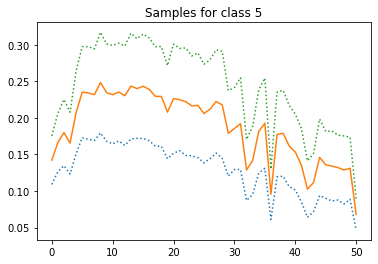

 69%|██████████████████████████████████████████████████▎                      | 69000/100000 [2:01:13<50:32, 10.22it/s]

Iter-69000; D_loss: -0.0007311839144676924; G_loss: -0.19618012011051178; C_loss: 0.0074725039303302765


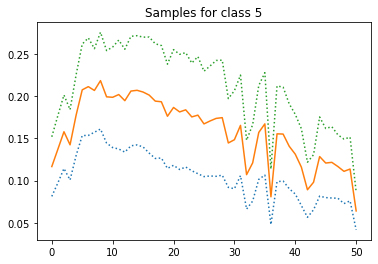

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 70%|███████████████████████████████████████████████████                      | 70000/100000 [2:02:52<47:02, 10.63it/s]

Iter-70000; D_loss: -0.0011934221256524324; G_loss: -0.1982453465461731; C_loss: 0.007352042477577925


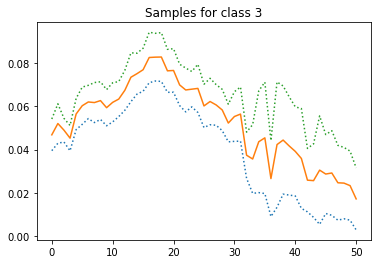

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 71%|███████████████████████████████████████████████████▊                     | 71000/100000 [2:04:31<47:30, 10.17it/s]

Iter-71000; D_loss: 0.0004276959225535393; G_loss: -0.19481602311134338; C_loss: 0.011151263490319252


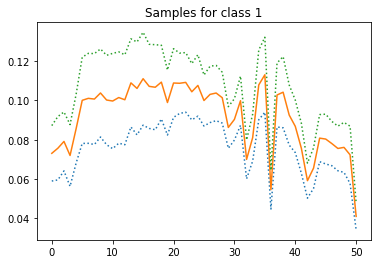

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 72%|████████████████████████████████████████████████████▌                    | 72000/100000 [2:06:10<45:25, 10.27it/s]

Iter-72000; D_loss: -0.0025164829567074776; G_loss: -0.19601574540138245; C_loss: 0.01351047120988369


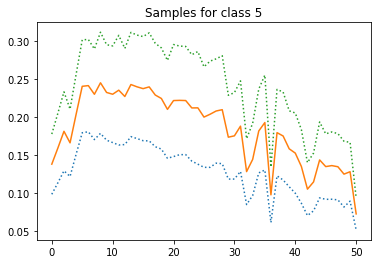

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 73%|█████████████████████████████████████████████████████▎                   | 73000/100000 [2:07:48<44:36, 10.09it/s]

Iter-73000; D_loss: 0.0007630705367773771; G_loss: -0.19165612757205963; C_loss: 0.008562694303691387


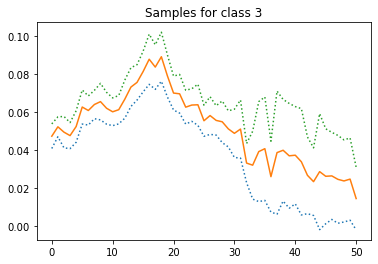

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 74%|██████████████████████████████████████████████████████                   | 73999/100000 [2:09:26<42:34, 10.18it/s]

Iter-74000; D_loss: -0.0010565202683210373; G_loss: -0.1926322877407074; C_loss: 0.006912209093570709


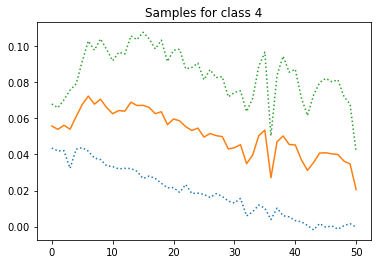

 75%|██████████████████████████████████████████████████████▊                  | 75000/100000 [2:11:06<41:37, 10.01it/s]

Iter-75000; D_loss: -0.0006426959298551083; G_loss: -0.19218721985816956; C_loss: 0.009855414740741253


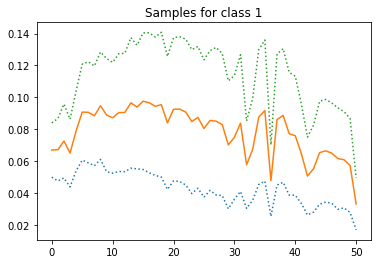

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 76%|███████████████████████████████████████████████████████▍                 | 75999/100000 [2:12:44<38:22, 10.42it/s]

Iter-76000; D_loss: 0.001903956988826394; G_loss: -0.19030672311782837; C_loss: 0.008598881773650646


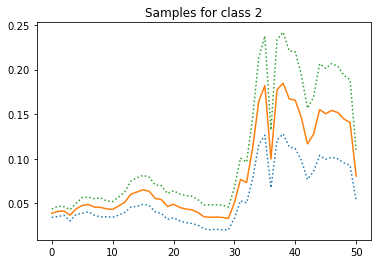

 77%|████████████████████████████████████████████████████████▏                | 77000/100000 [2:14:23<37:38, 10.18it/s]

Iter-77000; D_loss: 0.0009955537971109152; G_loss: -0.19304561614990234; C_loss: 0.011890496127307415


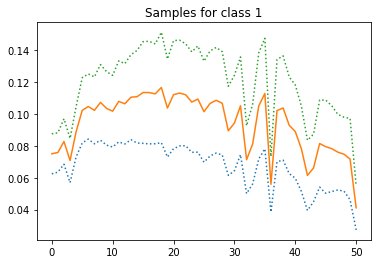

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 78%|████████████████████████████████████████████████████████▉                | 77999/100000 [2:16:02<35:07, 10.44it/s]

Iter-78000; D_loss: -0.0004438054747879505; G_loss: -0.19047389924526215; C_loss: 0.009744152426719666


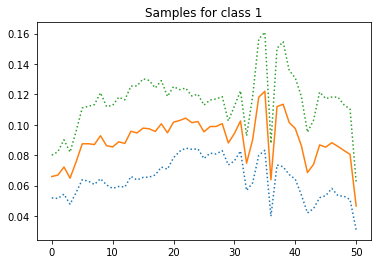

 79%|█████████████████████████████████████████████████████████▋               | 79000/100000 [2:17:41<34:12, 10.23it/s]

Iter-79000; D_loss: -0.00369145511649549; G_loss: -0.1909027099609375; C_loss: 0.012170462869107723


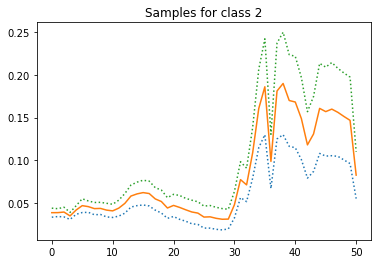

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 80%|██████████████████████████████████████████████████████████▍              | 80000/100000 [2:19:19<31:59, 10.42it/s]

Iter-80000; D_loss: -0.0009235442848876119; G_loss: -0.18713054060935974; C_loss: 0.008428568951785564


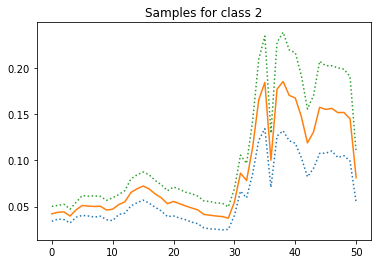

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 81%|███████████████████████████████████████████████████████████▏             | 81000/100000 [2:20:58<30:27, 10.40it/s]

Iter-81000; D_loss: 0.0002016131766140461; G_loss: -0.18990173935890198; C_loss: 0.009596544317901134


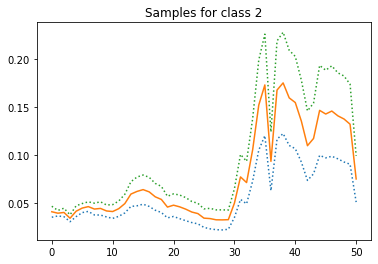

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 82%|███████████████████████████████████████████████████████████▊             | 81999/100000 [2:22:37<29:21, 10.22it/s]

Iter-82000; D_loss: 0.00042071123607456684; G_loss: -0.18760834634304047; C_loss: 0.007159275468438864


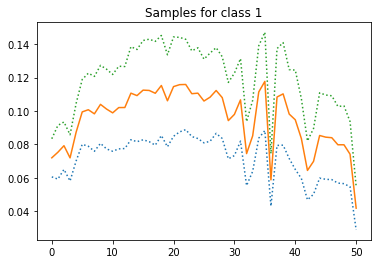

 83%|████████████████████████████████████████████████████████████▌            | 83000/100000 [2:24:16<27:16, 10.39it/s]

Iter-83000; D_loss: -0.0010172529146075249; G_loss: -0.19112882018089294; C_loss: 0.00791981816291809


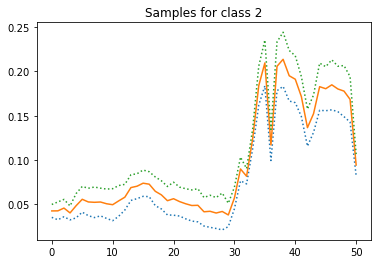

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 84%|█████████████████████████████████████████████████████████████▎           | 83999/100000 [2:25:54<26:08, 10.20it/s]

Iter-84000; D_loss: -0.0020131918136030436; G_loss: -0.1904745101928711; C_loss: 0.008372122421860695


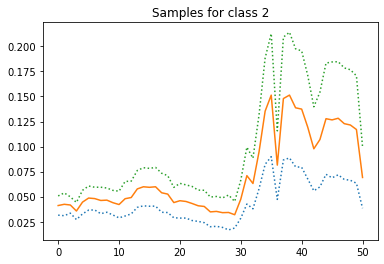

 85%|██████████████████████████████████████████████████████████████           | 84999/100000 [2:27:33<23:48, 10.50it/s]

Iter-85000; D_loss: -0.0007064498495310545; G_loss: -0.19419676065444946; C_loss: 0.005951413419097662


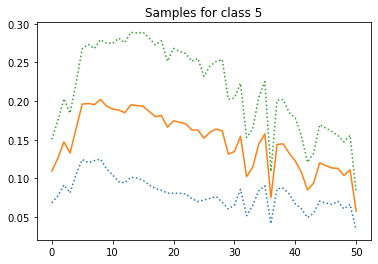

 86%|██████████████████████████████████████████████████████████████▊          | 86000/100000 [2:29:12<22:11, 10.51it/s]

Iter-86000; D_loss: -0.000722478493116796; G_loss: -0.1944638192653656; C_loss: 0.006394136697053909


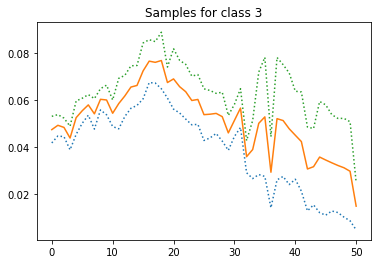

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 87%|███████████████████████████████████████████████████████████████▌         | 86999/100000 [2:30:51<21:11, 10.23it/s]

Iter-87000; D_loss: 0.001060144742950797; G_loss: -0.18552954494953156; C_loss: 0.006297993939369917


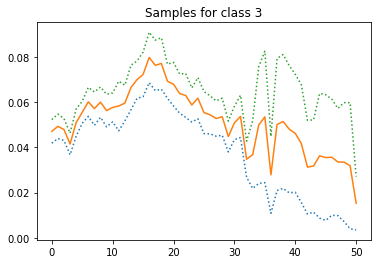

 88%|████████████████████████████████████████████████████████████████▏        | 87999/100000 [2:32:30<19:09, 10.44it/s]

Iter-88000; D_loss: 0.0008851967286318541; G_loss: -0.19061130285263062; C_loss: 0.006526981480419636


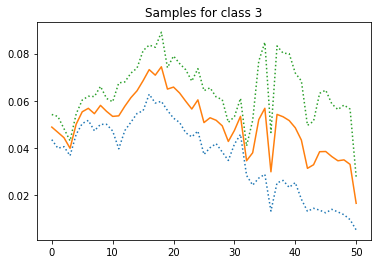

 89%|████████████████████████████████████████████████████████████████▉        | 88999/100000 [2:34:09<17:40, 10.38it/s]

Iter-89000; D_loss: -0.0021444919984787703; G_loss: -0.18660278618335724; C_loss: 0.009793742559850216


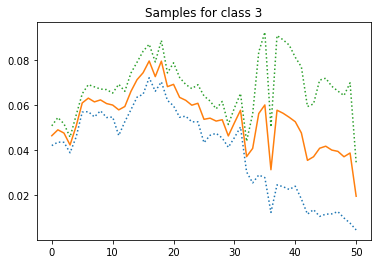

 90%|█████████████████████████████████████████████████████████████████▋       | 89999/100000 [2:35:48<15:56, 10.46it/s]

Iter-90000; D_loss: -0.006940651219338179; G_loss: -0.18714502453804016; C_loss: 0.01427451428025961


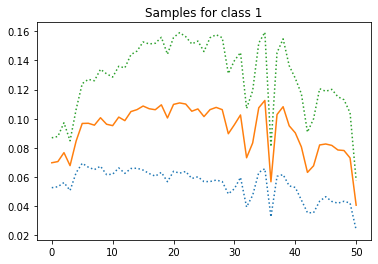

 91%|██████████████████████████████████████████████████████████████████▍      | 90999/100000 [2:37:26<14:50, 10.11it/s]

Iter-91000; D_loss: 0.000462312251329422; G_loss: -0.19210964441299438; C_loss: 0.005853697191923857


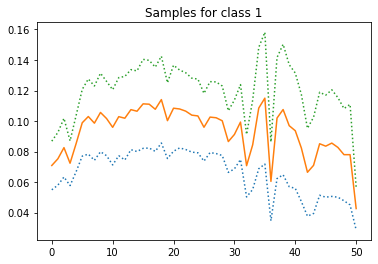

 92%|███████████████████████████████████████████████████████████████████▏     | 92000/100000 [2:39:05<12:49, 10.40it/s]

Iter-92000; D_loss: -0.009050015360116959; G_loss: -0.18991893529891968; C_loss: 0.009664556011557579


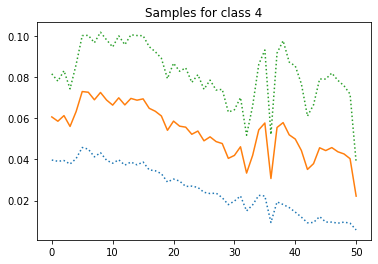

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 93%|███████████████████████████████████████████████████████████████████▉     | 93000/100000 [2:40:44<11:04, 10.53it/s]

Iter-93000; D_loss: 0.0006685699336230755; G_loss: -0.19360210001468658; C_loss: 0.007166119758039713


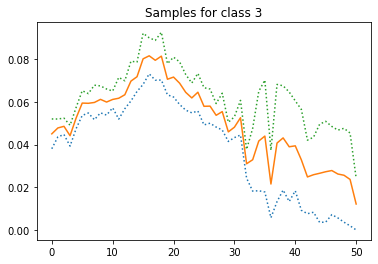

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 94%|████████████████████████████████████████████████████████████████████▌    | 94000/100000 [2:42:23<09:41, 10.32it/s]

Iter-94000; D_loss: -0.0009320524986833334; G_loss: -0.19636493921279907; C_loss: 0.004480014089494944


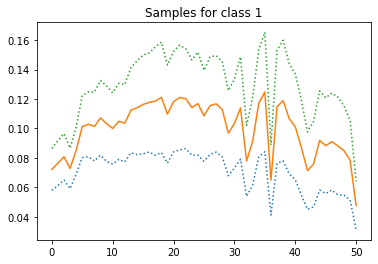

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 95%|█████████████████████████████████████████████████████████████████████▎   | 95000/100000 [2:44:01<07:58, 10.45it/s]

Iter-95000; D_loss: 0.002079834695905447; G_loss: -0.19883519411087036; C_loss: 0.006471178960055113


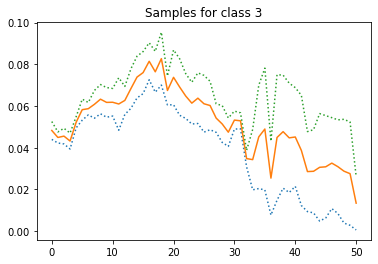

C:\Users\golde\anaconda3\envs\aerorit\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
 96%|██████████████████████████████████████████████████████████████████████   | 95999/100000 [2:45:40<06:34, 10.14it/s]

Iter-96000; D_loss: -0.002394135110080242; G_loss: -0.20179224014282227; C_loss: 0.004769802093505859


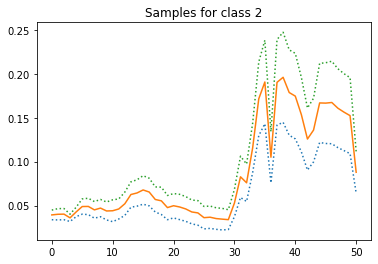

 97%|██████████████████████████████████████████████████████████████████████▊  | 97000/100000 [2:47:21<05:06,  9.79it/s]

Iter-97000; D_loss: -1.809094101190567e-05; G_loss: -0.20137909054756165; C_loss: 0.004990989342331886


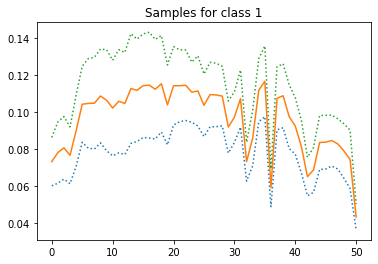

 98%|███████████████████████████████████████████████████████████████████████▌ | 97999/100000 [2:49:03<03:15, 10.24it/s]

Iter-98000; D_loss: 0.0002067028544843197; G_loss: -0.19449613988399506; C_loss: 0.006512213498353958


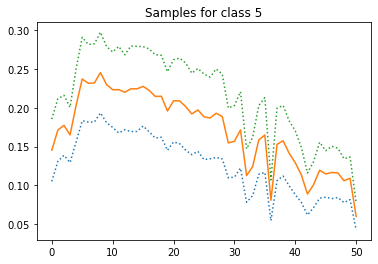

 99%|████████████████████████████████████████████████████████████████████████▎| 99000/100000 [2:50:46<01:39, 10.02it/s]

Iter-99000; D_loss: -0.004634344018995762; G_loss: -0.19620275497436523; C_loss: 0.00876519177109003


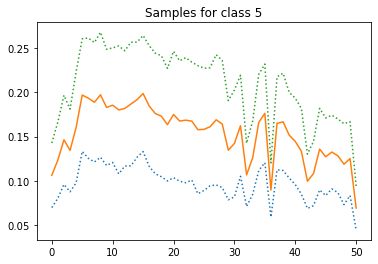

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [2:52:29<00:00,  9.66it/s]


In [14]:
# Get networks
G = Generator().cuda()
D = Discriminator().cuda()
C = Classifier().cuda()

# Use RMSProp optimizer
G_solver = optim.RMSprop(G.parameters(), lr=lr)
D_solver = optim.RMSprop(D.parameters(), lr=lr)
C_solver = optim.RMSprop(C.parameters(), lr=lr)

for it in tqdm(range(100000)):
    ###########################
    # (1) Update C and D      #
    ###########################
    for p in D.parameters():  # reset requires_grad
        p.requires_grad = True  # they are set to False below in netG update
    for p in C.parameters():
        p.requires_grad = True
    
    # D is trained d_step times for each iteration
    
    for _, (X, y), (X_, y_) in zip(range(d_step), data_loader, data_loader):
        D.zero_grad()

        # Sample random noise
        z = torch.randn(y.size(0), z_dim).squeeze()
        X, y = X.float(), y.float()
        X_, y_ = X_.float(), y_.float()
        # Mixup
        lam = np.random.beta(mixup_alpha, mixup_alpha)
        X = lam*X + (1. - lam)*X_
        X, y, z = X.cuda(), y.cuda(), z.cuda()
        y_ = y_.cuda()
        
        # Get discriminator prediction on real samples
        D_real = D(X).mean()
        # Get discriminator prediction on fake samples
        fake_samples = G(z, y)
        D_fake = D(fake_samples).mean()
        # Compute gradient penalty
        gradient_penalty = calc_gradient_penalty(D, X.data, fake_samples.data)
        # Compute loss and backpropagate
        D_loss = D_fake - D_real + gradient_penalty
        flip = np.random.random() < flip_percentage
        if flip: 
            # Flip real and fake
            gradient_penalty = calc_gradient_penalty(D, fake_samples.data, X.data)
            D_loss = D_real - D_fake + gradient_penalty
        D_loss.backward()
        D_solver.step()
    
        ######################
        #  Update C network  #
        ######################
        C.zero_grad()
        # Get class values
        _, classes = torch.max(y, dim=1)
        _, classes_ = torch.max(y_, dim=1)
        # Get predictions from C
        if flip:
            fake_samples = G(z, y)
            pred = C(fake_samples)
            # Compute loss and backpropagate
            C_loss = F.cross_entropy(pred, classes, weight=class_weights)
        else:
            pred = F.log_softmax(C(X))
            C_loss = lam * F.nll_loss(pred, classes) + (1. - lam) * F.nll_loss(pred, classes_)
        C_loss.backward()
        C_solver.step()


    ############################
    # (2) Update G network
    ###########################
    for p in D.parameters():
        p.requires_grad = False  # to avoid computation
    for p in C.parameters():
        p.requires_grad = False
    reset_grad(C, G, D)

    # Sample random noise
    z = torch.randn(y.size(0), z_dim).squeeze()
    z = z.cuda()
    # Generate fake samples
    G_sample = G(z, y)
    D_fake = D(G_sample)
    pred = C(G_sample)
    C_loss = F.cross_entropy(pred, classes, weight=class_weights)
    # Fool the discriminator (WGAN)
    G_loss = -torch.mean(D_fake)
    # Include the auxialiary classifier loss (AC-GAN)
    loss = G_loss + c_weight * C_loss
    # Backpropagate
    loss.backward()
    G_solver.step()

    # Print and plot every now and then
    if it % 1000 == 0:
        with torch.no_grad():
            print('Iter-{}; D_loss: {}; G_loss: {}; C_loss: {}'.format(it,
                                                           D_loss.data.cpu().numpy(), G_loss.data.cpu().numpy(),
                                                           C_loss.data.cpu().numpy()))
            z = torch.randn(mb_size, z_dim).squeeze().cuda()
            c = np.zeros(shape=[mb_size, c_dim], dtype='float32')
            idx = np.random.randint(1, data_loader.dataset.n_classes)
            c[:, idx] = 1.
            c = torch.from_numpy(c).squeeze().cuda()
            samples = G(z, c).data.cpu().numpy()[:16]
            pred = G(z, c)
            plot_mean_std(samples)
            plt.title("Samples for class {}".format(idx))
            plt.show()

## Data generation

Now that the generator has been trained, we can generate some fake spectra and see how they fare visually against the real ones.

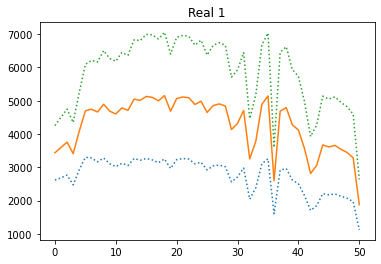

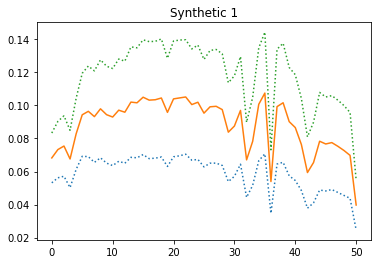

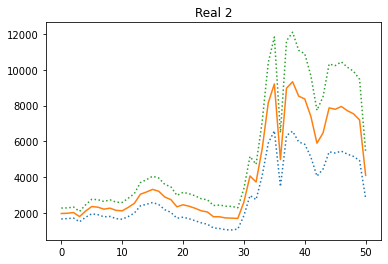

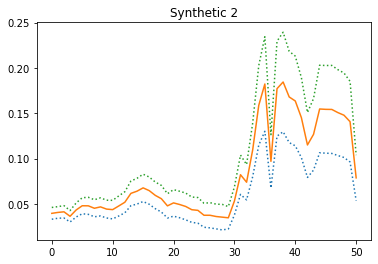

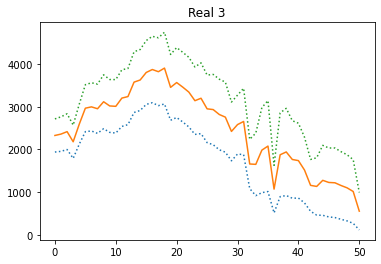

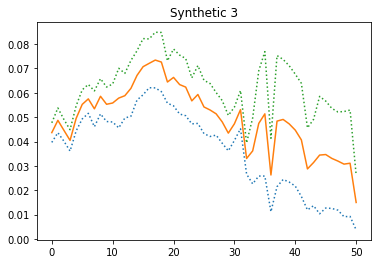

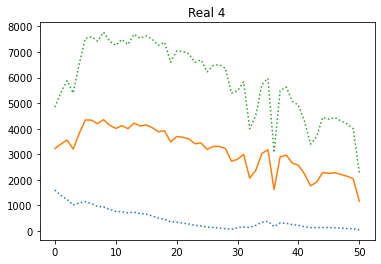

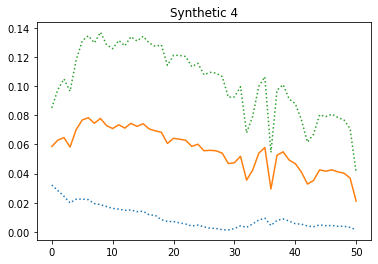

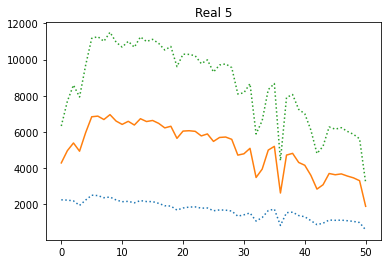

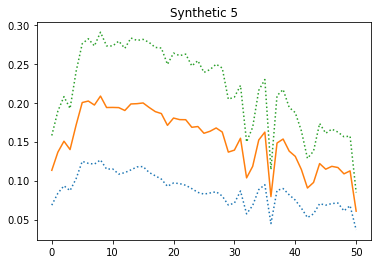

In [15]:
for c in np.unique(gt):
    # 0 is the "undefined" class
    if c == 0:
        continue
    
    # Get the mean spectrum +- std for this class
    spectras = img[gt == c, :]
    plot_mean_std(spectras)
    plt.title("Real {}".format(c))
    plt.show()
    
    # Get as many fake spectras as real ones
    synthetic_spectras = []
    with torch.no_grad():
        while len(synthetic_spectras) < len(spectras):
            z = torch.randn(mb_size, z_dim).cuda()
            y = torch.from_numpy(np.eye(data_loader.dataset.n_classes)[c]).float()
            y = y.unsqueeze(0).repeat(mb_size, 1).cuda()
            G_sample = G(z, y)
            _, classes = torch.max(y, 1)
            _, pred = torch.max(C(G_sample), 1)
            synthetic_spectras += list(G_sample.cpu().data.numpy())
    plt.show()
    plot_mean_std(synthetic_spectras)
    plt.title("Synthetic {}".format(c))
    plt.show()

In [16]:
torch.cuda.empty_cache()


### SVM on fake data

We now generate some fake data (in the same quantities as the real data) and apply the trained SVM on it.

In [17]:
def gan_create_fake_dataset(labels):
    with torch.no_grad():
        spectras = []
        for l in np.array_split(labels, len(labels) // mb_size):
            
            z = torch.randn(len(l), z_dim).cuda()
            y = np.zeros((len(l), data_loader.dataset.n_classes))
            for i, label in enumerate(l):
                y[i] = np.eye(data_loader.dataset.n_classes)[label]
            y = torch.from_numpy(y).float()
            eps = torch.randn(y.size())/10
            #y += eps
            y = y.cuda()
            G_sample = G(z, y)
            spectras += list(G_sample.cpu().data.numpy())
        return np.array(spectras), np.array(labels)

In [18]:
# (unique, counts) = np.unique(gt, return_counts=True)
# frequencies = np.asarray((unique, counts)).T
# print(frequencies)

In [19]:
from PIL import Image
gt_zip = zip(*np.nonzero(gt))
_gt = np.array([gt[x,y] for x,y in gt_zip])
# _axis_x = np.array([x for x,y in gt_zip])
# _axis_y = np.array([y for x,y in gt_zip])
out_pixels, out_gt_img = gan_create_fake_dataset(_gt)
input_width = np.shape(img)[0]
input_height = np.shape(img)[1]

# test_img = np.reshape(out_img,(input_width,-1,X_dim) )
# print(np.shape(test_img))
print(np.shape(_gt))
print(np.shape(img))
print(out_pixels.shape)
print(_gt)

(828154,)
(1220, 680, 51)
(828154, 51)
[2 2 2 ... 1 1 1]


In [21]:
out_img = np.array(img, copy=True)

# print(out_img.shape)
# print(_gt)
out_indexes = np.array([(x, y) for x,y in zip(*np.nonzero(gt))]).astype(np.uint8)
print(out_indexes.shape)
np.put(out_img,out_indexes,out_pixels)            

(828154, 2)


In [ ]:
print(np.shape(out_img))
print(np.shape(out_gt_img))

In [ ]:
# test_shape = io.imread('C:\\Users\\golde\\Documents\\GitHub\\AeroRIT\\Aerial Data\\Collection\\image_hsi_radiance.tif')
# print(np.shape(test_shape))

In [23]:
from tifffile import imsave
rotated_back = np.transpose(out_img, [2,0,1])
imsave('./output_images/test.tif', rotated_back)
print(rotated_back.shape)

(51, 1220, 680)


In [ ]:
# _counts = np.asarray(np.unique(rotated_back,return_counts=True))
# print(len(_counts[0]),_counts.T)
# _counts = np.asarray(np.unique(out_pixels,return_counts=True))
# print(len(_counts[0]),_counts.T)
# _counts = np.asarray(np.unique(img,return_counts=True))
# print(len(_counts[0]),_counts.T)

In [ ]:
# pavia_img = loadmat('./PaviaU.mat')['paviaU']
# print(np.transpose(rotated_back, [2,1,0])[0][0])
# print(img[0][0])
# print(pavia_img[0][0])

In [ ]:
# matplotlib.image.imsave("./output_images/test_rgb.png", np.transpose(rotated_back, [2,1,0])[:,:,(43,24,4)])

In [ ]:
import scipy.io as sio
from tifffile import imsave
import matplotlib

# 
# imsave('./output_images/test.tif', rotated_back)



# matplotlib.image.imsave("./output_images/out_img.tif", out_img)
# im = Image.new('L', (input_width, input_height))
# im.putdata(out_img.flatten().tolist())
# im.save("filename.tiff", format="TIFF", save_all=True)
# out_rgb = out_img[:,:,(54,41,12)]
out_rgb = out_img[:,:,(44,12,6)]
out_rgb = (255 * (out_rgb.astype(np.float32) - out_rgb.min())/(out_rgb.max() - out_rgb.min())).astype(np.uint8)
plt.imshow(out_rgb)
# matplotlib.image.imsave("./output_images/out_rgb.png", out_rgb)


# savedict = {
#     'paviaU_out' : out_img,
# }
# sio.savemat('./output_images/out_img_pavia.mat', savedict)

#out_gt_img = Image.fromarray(out_gt_img)
#out_img.save("./output_images/out_img.tif")
#out_gt_img.save("./output_images/out_gt_img.png")